In [5]:
import numpy as np
import matplotlib as cm
import matplotlib.pyplot as plt
import scipy.stats as st
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D  
import time

In [6]:
data1 = np.random.multivariate_normal([0,0,0], 0.01*np.eye(3), 40)
data2 = np.random.multivariate_normal([0,0,1], 0.01*np.eye(3), 40)
data3 = np.random.multivariate_normal([0,1,0], 0.01*np.eye(3), 40)
data4 = np.random.multivariate_normal([1,0,0], 0.01*np.eye(3), 40)

data = np.concatenate((np.concatenate((data1, data2)), data3))
data = np.concatenate((data, data4))

In [9]:
#Data of shape (n,p)
class DirichletMixtureConjugate:
    #Data of shape (n,p) where p is the dimensionality of cluster, *arg refers to the four prior hyperparameters of the normal inverse wishart
    def __init__(self, data, K_ini = None, alpha = 1,lamb = 0.1, standardize = True, **kwargs):
        ## Integrate data
        if standardize:
            data = (data - np.mean(data, axis = 0))/(np.std(data, axis = 0))
        self.data = data
        (n,p) = data.shape
        if K_ini == None:
            K_ini = int(np.log(n)) + 1
        
        ## Normal-Inverse Wishart hyperparameters
        self.mu = kwargs.get("mu", np.zeros(p))
        self.lamb = lamb
        self.psi = kwargs.get("psi", 10*np.eye(p))
        self.nu = kwargs.get("nu", 100)
        self.alpha = alpha
        
        ## Initialize state of the Markov Chain, we take one cluster theta and labels
        self.nLabels = K_ini # Number of labels
        nPerCluster, nRemaining = n // K_ini, n % K_ini
        self.countLabels = [nPerCluster + 1 if i < nRemaining else nPerCluster for i in range(K_ini)] # number of elements in each label
        self.labels = np.array([i for i in range(K_ini) for j in range(self.countLabels[i])]) #for each observation, label, starting at 0
        self.parameters = [[np.zeros(p), np.eye(p)] for i in range(K_ini)]
        
        ## History fitting
        self.history = {"nbClusters" : [self.nLabels], "logLikelihood" : []}
        self.plot()
    
    # Compute posterior probability
    def computeLogLikelihood(self):
        n = self.data.shape[0]
        score = 0
        for i in range(n):
            score += st.multivariate_normal.logpdf(self.data[i], self.parameters[self.labels[i]][0], self.parameters[self.labels[i]][1])
        return score
    
    # Update the attributes to perform posterior sampling
    def updatePosteriorParam(self, label):
        subData = self.data[self.labels == label,:]
        ## Parameters of the Posterior distribution
        yBar = np.mean(subData, axis = 0)
        n = subData.shape[0]
        S = sum(map(lambda x: np.outer(x,x), subData))
        self.lambPost = self.lamb + n
        self.nuPost = self.nu + n
        self.muPost = (self.lamb*self.mu + n*yBar)/(self.lambPost)
        self.psiPost = (self.nu/(self.nuPost))*self.psi + (1/(self.nuPost))*S + self.lamb*(np.outer(self.mu,self.mu)) + self.lambPost*(np.outer(self.muPost,self.muPost))
        
    # Perform gibbs sampling on a whole round of labels and parameters
    def gibbsSampling(self):
        (n,p) = self.data.shape
        ## 2) Sample with regards to the labels:
        perm = np.random.permutation(n)
        for i in perm:
            ## Remove i from its cluster / Can be computationally improved by keeping a dictionaty up to date
            currLabel = self.labels[i]
            self.labels[i] = -1
            if self.countLabels[currLabel] == 1:
                self.labels[self.labels > currLabel] -= 1
                self.parameters.pop(currLabel)
                self.nLabels -= 1
                self.countLabels.pop(currLabel)
            else:
                self.countLabels[currLabel] -= 1
            
            ## Compute probabilities of the sampling
            preprobs = list(map(lambda y: y[0] * st.multivariate_normal.pdf(self.data[i], y[1][0], y[1][1]) , zip(self.countLabels,self.parameters)))
            preprobs.append(self.alpha * st.multivariate_normal.pdf(self.data[i], self.mu,  (((self.lamb + 1)*(self.nu))/((self.lamb)*(self.nu - p - 1)))*self.psi))
            probs = np.array(preprobs)
            
            ## Choose
            choice = np.random.multinomial(1,probs/(np.sum(probs)))
            chosenLabel = np.where(choice == 1)[0][0]
            
            ## If new label
            if chosenLabel == self.nLabels:
                ### Sample posterior parameters / Update attributes
                self.countLabels.append(1)
                self.labels[i] = self.nLabels
                self.nLabels += 1
                self.updatePosteriorParam(chosenLabel)
                psiStar = st.invwishart.rvs(self.nuPost, self.psiPost)
                muStar = np.random.multivariate_normal(self.muPost, (1/self.lambPost)*psiStar)
                self.parameters.append([muStar, psiStar])
            else:
                self.countLabels[chosenLabel] += 1
                self.labels[i] = chosenLabel
                
        ## 1) Sample with regards to the parameters
        for label in range(self.nLabels):
            self.updatePosteriorParam(label)
            psiStar = st.invwishart.rvs(self.nuPost, self.psiPost)
            muStar = np.random.multivariate_normal(self.muPost, (1/self.lambPost)*psiStar)
            self.parameters[label] = [muStar, psiStar]
            
    def fit(self, epoch = 100, vis = False):
        for i in range(epoch):
            self.gibbsSampling()
            self.history["nbClusters"].append(self.nLabels)
            self.history["logLikelihood"].append(self.computeLogLikelihood())
            if vis:
                self.plot()
            #time.sleep(1)
    
    ### Plot data when p <= 2
    def plot(self):
        if self.data.shape[1] == 2:
            def eigsorted(cov):
                vals, vecs = np.linalg.eigh(cov)
                order = vals.argsort()[::-1]
                return vals[order], vecs[:,order]
            x = self.data[:,0]
            y = self.data[:,1]
            nstd = 1
            ax = plt.subplot(111)
            for parameter in diri.parameters:
                cov = parameter[1]
                vals, vecs = eigsorted(cov)
                theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
                w, h = 2 * nstd * np.sqrt(vals)
                ell = Ellipse(xy=(parameter[0][0], parameter[0][1]),
                              width=w, height=h,
                              angle=theta, color='black')
                ell.set_facecolor('none')
                ax.add_artist(ell)
            N = 10
            cmap = plt.cm.jet
            cmaplist = [cmap(i) for i in range(cmap.N)]
            cmap = cmap.from_list('Custom cmap', cmaplist)
            plt.scatter(diri.data[:,0], self.data[:,1], c = np.array(self.labels), cmap = cmap)
            plt.show()
        
        elif self.data.shape[1] == 3:
            fig = plt.figure()
            cmap = plt.cm.jet
            cmaplist = [cmap(i) for i in range(cmap.N)]
            cmap = cmap.from_list('Custom cmap', cmaplist)
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(self.data[:,0], self.data[:,1], self.data[:,2], c = np.array(self.labels), cmap = cmap)
            plt.show()
        else :
            print("Too many dimensions")

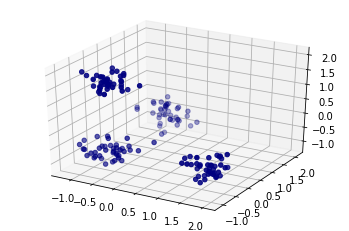

In [10]:
diri = DirichletMixtureConjugate(data, K_ini = 1)

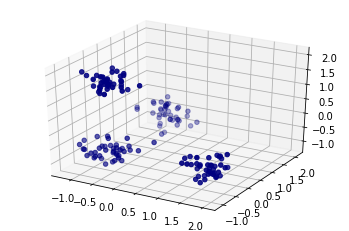

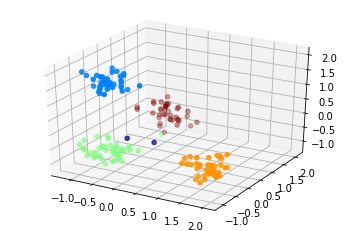

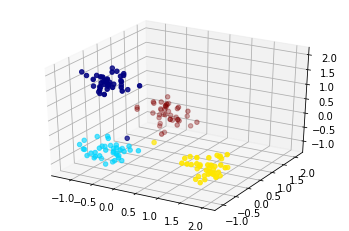

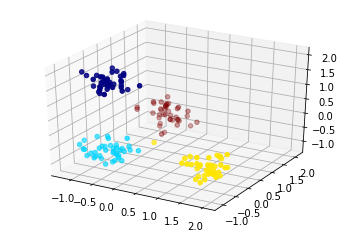

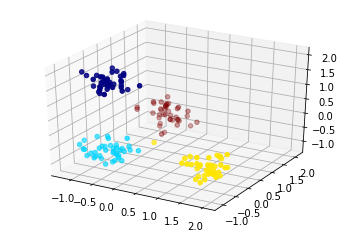

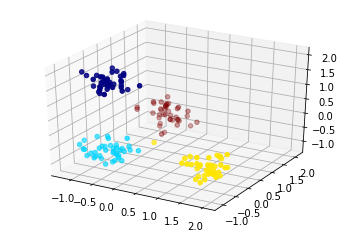

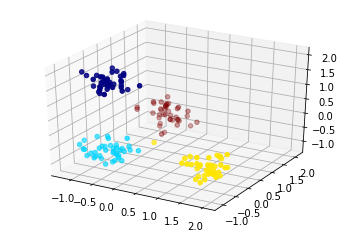

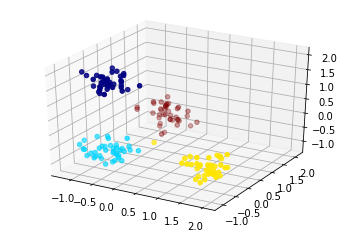

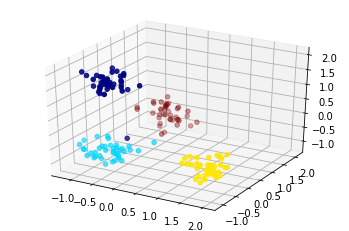

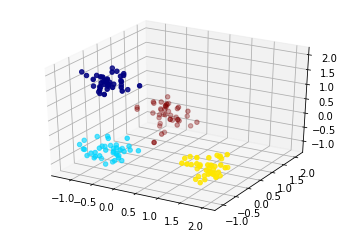

In [11]:
diri.fit(epoch = 10, vis = True)

In [664]:
diri.parameters

[[array([-0.71530442,  0.59373585]), array([[ 0.22035937, -0.18002972],
         [-0.18002972,  0.20749384]])],
 [array([ 0.56049508, -0.78374743]), array([[ 0.10554851, -0.1060664 ],
         [-0.1060664 ,  0.20550247]])],
 [array([ 1.2019668 , -0.51902641]), array([[ 0.41874715, -0.17557147],
         [-0.17557147,  0.16709269]])]]

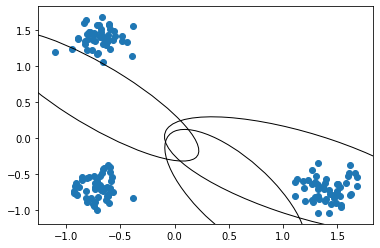

In [665]:
diri.plot()

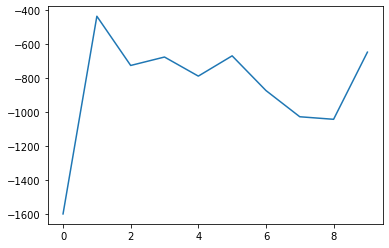

In [672]:
plt.plot(diri.history["logLikelihood"])

In [467]:
diri.labels

array([ 2,  0,  6,  2,  2,  6,  2,  6,  3,  0,  2,  0,  4,  4,  9,  2,  1,
        4,  2,  5,  6,  6,  5,  0,  2,  6,  0,  6,  2,  0,  0,  6,  2,  9,
        4,  0,  4,  2,  4,  2,  5,  3,  9,  3,  2,  2,  3,  0,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  7,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  9,  9,
        9,  9, 15, 15,  9,  6,  9,  6, 15,  9,  9,  9, 16,  9, 14, 15,  6,
       15, 11,  9,  6,  9,  9, 10,  8, 12,  9,  9,  6,  6, 15,  9, 15, 13,
        9, 15,  6,  9, 15, 15,  6,  9,  9,  9, 15,  9, 15,  9])

In [484]:
diri.parameters

[[array([-0.49969533, -0.51121839]), array([[0.46285736, 0.46301862],
         [0.46301862, 0.46447018]])],
 [array([-0.60698319, -0.63356631]), array([[0.43620481, 0.44459262],
         [0.44459262, 0.45505921]])],
 [array([ 1.26128588, -0.60789754]), array([[ 2.01959814, -0.95956489],
         [-0.95956489,  0.45673072]])],
 [array([ 1.36720175, -0.72029181]), array([[ 1.42458049, -0.73505568],
         [-0.73505568,  0.38011469]])],
 [array([-0.64126459,  1.32359679]), array([[ 0.46939055, -0.96646401],
         [-0.96646401,  1.99735345]])],
 [array([-0.71189267,  1.36563227]), array([[ 0.4075538 , -0.76918797],
         [-0.76918797,  1.45477393]])],
 [array([-0.21917968,  0.99411627]), array([[ 0.09358182, -0.36343502],
         [-0.36343502,  1.43722229]])],
 [array([ 5.06835225, -2.70724675]), array([[13.21499691, -6.84653329],
         [-6.84653329,  3.54884213]])],
 [array([ 0.48970915, -0.19601815]), array([[ 4.61189055, -1.78157128],
         [-1.78157128,  0.76267107]])],


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]),
 array([5.  , 5.01, 5.02, 5.03, 5.04, 5.05, 5.06, 5.07, 5.08, 5.09, 5.1 ,
        5.11, 5.12, 5.13, 5.14, 5.15, 5.16, 5.17, 5.18, 5.19, 5.2 , 5.21,
        5.22, 5.23, 5.24, 5.25, 5.26, 5.27, 5.28, 5.29, 5.3 , 5.31, 5.32,
        5.33, 5.34, 5.35, 5.36, 5.37, 5.38, 5.39, 5.4 , 5.41, 5.42, 5.43,
        5.44, 5.45, 5.46, 5.47, 5.48, 5.49, 5.5 , 5.51, 5.52, 5.53, 5.54,
        5.55, 5.56, 5.57, 5.58, 5.59, 5.6 , 5.61, 5.62, 5.63, 5.64, 5.65,
        5.66, 5.67, 5.68, 5.69, 5.7 , 5.71, 5.72, 5.73, 5.74, 5.75, 5.76,
        5.77, 5.78, 5.79, 5.8 , 

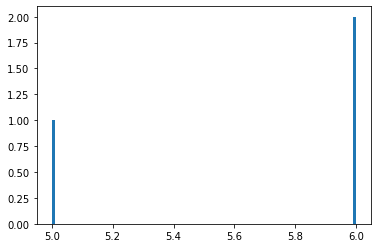

In [634]:
plt.hist(diri.history["nbClusters"],bins = 100)

In [603]:
st.invwishart.rvs(2, np.eye(2))

array([[4.85878799, 1.27069293],
       [1.27069293, 0.80878124]])

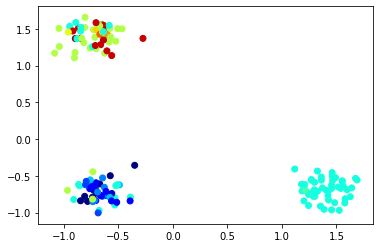

In [469]:
N = 3
cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist)
plt.scatter(diri.data[:,0], diri.data[:,1], c = np.array(diri.labels), cmap = cmap)

In [611]:
st.invwishart.rvs(100, np.eye(2))

array([[ 0.01068795, -0.00165317],
       [-0.00165317,  0.00943544]])